## <center>Обучение с учителем. Методы классификации
### <center>Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

In [95]:
import numpy as np
import pandas as pd

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 45)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 80)

import gc
import pickle

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split, StratifiedKFold)

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from scipy.stats import normaltest, norm

from sklearn.preprocessing import QuantileTransformer

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

import graphviz
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

**Считываем обучающую и тестовую выборки.**

In [96]:
train_df = pd.read_csv("titanic_train.csv") 
test_df = pd.read_csv("titanic_test.csv") 

In [97]:
train_df.shape
test_df.shape

(891, 12)

(418, 11)

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [99]:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [100]:
test_df.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [101]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [102]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [103]:
y = train_df['Survived']

In [104]:
y.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Обработка пропущенных значений

In [105]:
# Функция скопированна (считаем число пропущенных значений)
def missing_values_table(df):
        mis_val = df.isnull().sum()        
        mis_val_percent = 100 * df.isnull().sum() / len(df)        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Пропущенные значения', 
                   1 : '% от общего количества значений'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% от общего количества значений', ascending=False).round(1)
        
        return mis_val_table_ren_columns

In [106]:
missing_values_table(train_df)

,Пропущенные значения,% от общего количества значений
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


In [107]:
missing_values_table(test_df)

,Пропущенные значения,% от общего количества значений
Cabin,327,78.2
Age,86,20.6
Fare,1,0.2


**`train_df.Embarked`**

In [108]:
train_df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [109]:
# 2 пропущенных значения Embarked заполняем модой
train_df.Embarked.mode()[0]
train_df.Embarked.fillna(train_df.Embarked.mode()[0], inplace = True)

'S'

**`test_df.Fare`**

In [110]:
test_df[test_df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Пропущенное значение стоимости билета заполним медианой с учетом имеющихся условий - путешествующий 3-м классом (`'Pclass'`) мужчина (`'Sex'`) без детей (`'Parch'`), родственников и супруги (`'SibSp'`).

In [111]:
fare_median = test_df.groupby(['Pclass', 'Sex', 'Parch', 'SibSp']).median()['Fare'][3]['male'][0][0]
fare_median

7.8208

In [112]:
test_df['Fare'] = test_df['Fare'].fillna(fare_median)

**`train_df.Age`**

Для понимания, как эффективнее заполнять пропущенные значения `Age`, рассмотрим подробнее распределение и зависимость переменных.

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\BIASPA~1\AppData\Local\Temp/ipykernel_20964/3508972688.py:3: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None);


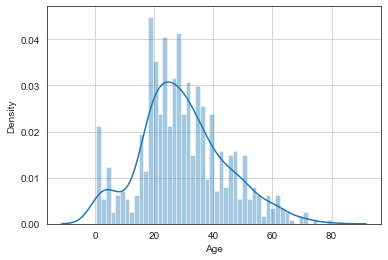

In [113]:
sns.set_style(style='white')
sns.distplot(train_df['Age'].dropna(), bins=50)
plt.grid(b=None);

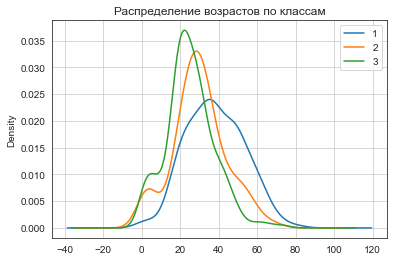

In [114]:
for x in [1,2,3]: 
    train_df.Age[train_df.Pclass == x].plot(kind="kde")
plt.title("Распределение возрастов по классам")
plt.legend(("1","2","3"))
plt.grid();

В среднем чем выше класс, тем старше пассажиры.

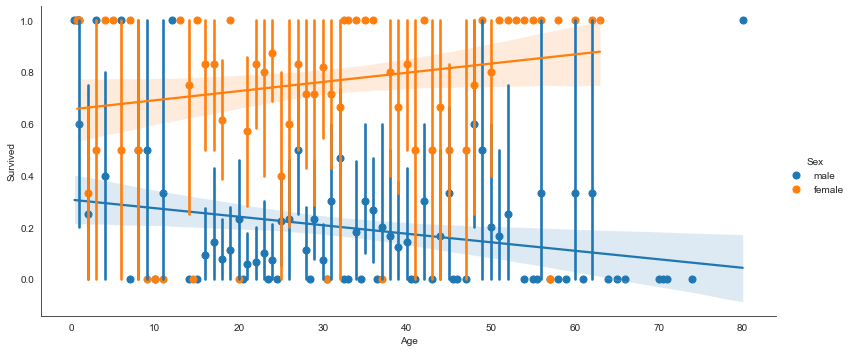

In [115]:
sns.lmplot(x='Age', y='Survived', hue="Sex", data=train_df, x_estimator=np.mean, 
           height=5.0, aspect=11.0/5.0);

Зависимость переменных `Age` и `Survived` разная в зависимости от пола пассажира.

Корреляция числовых переменных:

In [116]:
corrs = train_df.corr().abs()
np.fill_diagonal(corrs.values, 0)

s = corrs.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
so[so > 0.1] # только корреляция выше 0.1

Pclass    Fare        0.549500
Fare      Pclass      0.549500
Parch     SibSp       0.414838
SibSp     Parch       0.414838
Pclass    Age         0.369226
Age       Pclass      0.369226
Pclass    Survived    0.338481
Survived  Pclass      0.338481
Age       SibSp       0.308247
SibSp     Age         0.308247
Survived  Fare        0.257307
Fare      Survived    0.257307
          Parch       0.216225
Parch     Fare        0.216225
          Age         0.189119
Age       Parch       0.189119
SibSp     Fare        0.159651
Fare      SibSp       0.159651
dtype: float64

Переменная `Age` показывает относительно высокую корреляцию с `Pclass` (~ 0.37) и с `SibSp` (~ 0.31). 

Заполнять пропущенные значения `Age` будем медианой после группировки по классу, количеству братьев-сестер и супругов, полу пассажира.

In [117]:
age_pclass_sib_sex = train_df.groupby(['Pclass', 'SibSp', 'Sex']).median()

In [118]:
age_pclass_sib_sex.Age

Pclass  SibSp  Sex   
1       0      female    31.5
               male      40.0
        1      female    37.0
               male      38.0
        2      female    21.0
               male      47.0
        3      female    23.5
               male      19.0
2       0      female    30.0
               male      30.0
        1      female    27.5
               male      31.0
        2      female    24.0
               male      23.0
        3      female    30.0
3       0      female    22.0
               male      27.0
        1      female    28.5
               male      25.0
        2      female     7.0
               male      27.0
        3      female     8.0
               male       4.0
        4      female     7.5
               male       5.5
        5      female    16.0
               male      10.0
        8      female     NaN
               male       NaN
Name: Age, dtype: float64

И после вычисления медианы есть отсутствующие значения переменной `Age` для значения `SibSp` **8**, рассмотрим их отдельно, а пока заполним пропущенные значения.

In [119]:
train_df['Age'] = train_df.groupby(
    ['Pclass', 'SibSp', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

**`test_df.Age`**

In [120]:
# По аналогии с train_df.Age
test_df['Age'] = test_df.groupby(
    ['Pclass', 'SibSp', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

Проверка:

In [121]:
train_df[train_df['Age'].isnull()]
test_df[test_df['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
188,1080,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.55,NaN,S


Оставшиеся незаполненными сведения о возрасте относятся к членам одной семьи - Sage. По запросу в поиске Google "Sage, Master. Thomas Henry titanic" первая ссылка: https://www.encyclopedia-titanica.org/titanic-victim/thomas-henry-sage.html.

Интересно, что **номер билета один и тот же для членов одной семьи**, следовательно, информация о номере билета может быть использована для генерации информативного признака. 

Так как у нас уже есть информация о возрасте членов семьи Sage, внесем ее вручную.

In [122]:
train_df.loc[train_df.index == 159,'Age'] = 5.0         
train_df.loc[train_df.index == 180,'Age'] = 8.0                  
train_df.loc[train_df.index == 201,'Age'] = 17.0       
train_df.loc[train_df.index == 324,'Age'] = 20.0       
train_df.loc[train_df.index == 792,'Age'] = 21.0     
train_df.loc[train_df.index == 846,'Age'] = 19.0      
train_df.loc[train_df.index == 863,'Age'] = 15.0

test_df.loc[test_df.index == 188,'Age'] = 11.0  

**`train_df.Cabin`**, **`test_df.Cabin`**

In [123]:
# Номера кают
set(train_df.Cabin)

{'A10',
 'A14',
 'A16',
 'A19',
 'A20',
 'A23',
 'A24',
 'A26',
 'A31',
 'A32',
 'A34',
 'A36',
 'A5',
 'A6',
 'A7',
 'B101',
 'B102',
 'B18',
 'B19',
 'B20',
 'B22',
 'B28',
 'B3',
 'B30',
 'B35',
 'B37',
 'B38',
 'B39',
 'B4',
 'B41',
 'B42',
 'B49',
 'B5',
 'B50',
 'B51 B53 B55',
 'B57 B59 B63 B66',
 'B58 B60',
 'B69',
 'B71',
 'B73',
 'B77',
 'B78',
 'B79',
 'B80',
 'B82 B84',
 'B86',
 'B94',
 'B96 B98',
 'C101',
 'C103',
 'C104',
 'C106',
 'C110',
 'C111',
 'C118',
 'C123',
 'C124',
 'C125',
 'C126',
 'C128',
 'C148',
 'C2',
 'C22 C26',
 'C23 C25 C27',
 'C30',
 'C32',
 'C45',
 'C46',
 'C47',
 'C49',
 'C50',
 'C52',
 'C54',
 'C62 C64',
 'C65',
 'C68',
 'C7',
 'C70',
 'C78',
 'C82',
 'C83',
 'C85',
 'C86',
 'C87',
 'C90',
 'C91',
 'C92',
 'C93',
 'C95',
 'C99',
 'D',
 'D10 D12',
 'D11',
 'D15',
 'D17',
 'D19',
 'D20',
 'D21',
 'D26',
 'D28',
 'D30',
 'D33',
 'D35',
 'D36',
 'D37',
 'D45',
 'D46',
 'D47',
 'D48',
 'D49',
 'D50',
 'D56',
 'D6',
 'D7',
 'D9',
 'E10',
 'E101',
 'E12',
 

В сети есть информация о том, что буква в начале номера каюты определяет палубу, на которой она расположена. Создадим новую переменную `Deck`, которая будет содержать букву из переменной `Cabin`, если значение существует, и значение `abs`, если отсутствует.    

In [124]:
train_df['Deck'] = train_df.Cabin.str.slice(0,1)
train_df['Deck'] = train_df['Deck'].fillna('abs')

In [125]:
train_df.Deck.value_counts()

abs    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: Deck, dtype: int64

In [126]:
test_df['Deck'] = test_df.Cabin.str.slice(0,1)
test_df['Deck'] = test_df['Deck'].fillna('abs')

In [127]:
test_df.Deck.value_counts()

abs    327
C       35
B       18
D       13
E        9
F        8
A        7
G        1
Name: Deck, dtype: int64

In [128]:
# Только одно значение "Т" на обе выборки
train_df[train_df.Deck=='T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S,T


Заменим единичное значение **'T'** переменной `Deck` на значение **'С'** как самое частое из известных. 

In [129]:
train_df['Deck'] = train_df['Deck'].replace('T', 'C')

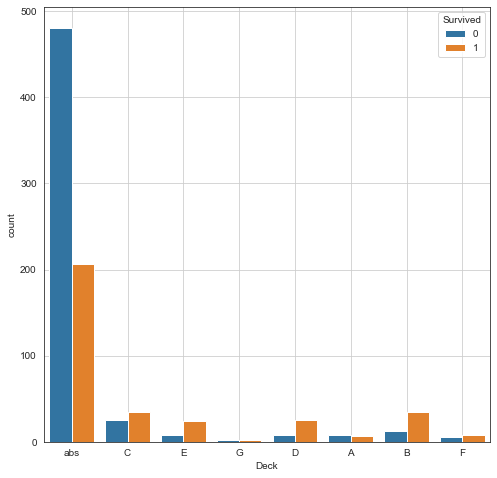

In [130]:
plt.figure(figsize=(8,8))
sns.countplot(x = "Deck", hue = "Survived", data = train_df)
plt.grid();

Зависимость выживаемости от палубы есть, оставляем переменную `Deck` вместо `Cabin`.

In [131]:
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [132]:
train_df.isnull().sum().sum()
test_df.isnull().sum().sum()

0

0

### Создание новых переменных

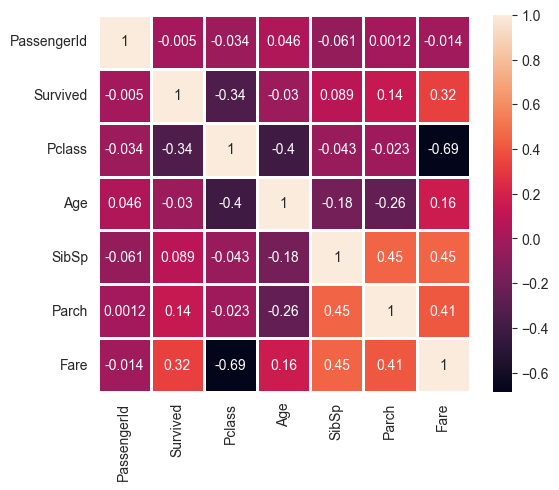

In [133]:
plt.figure(figsize=(6,5), dpi=100)
corr = train_df.corr(method='spearman')
sns.heatmap(corr, annot=True, linewidths=1);

**`Fare`**

У переменной `Fare` высокая прямая корреляция с `Survived`.

In [134]:
train_df.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [135]:
test_df.Fare.describe()

count    418.000000
mean      35.560666
std       55.857061
min        0.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: Fare, dtype: float64

In [136]:
len(train_df[train_df.Fare > 31])
len(train_df[train_df.Fare > 120])
len(train_df[train_df.Fare > 263])  # 3 пассажира со стоимостью билетов > 263
len(train_df[train_df.Fare > 512.3292])  # 3

222

38

3

0

Сделаем биннинг переменной `Fare`, результатом будет переменная `Fare_range`, определяемая диапазоном стоимости билета. При разбиении будем руководствоваться значениями квантилей и максимальной ценой билетов. 

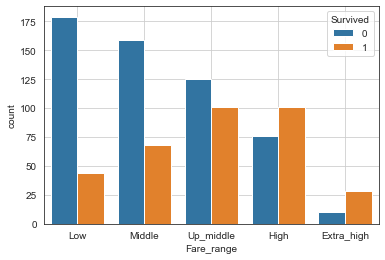

In [137]:
train_df['Fare_range'] = pd.cut(train_df['Fare'],
                                bins=[-np.inf, 7.90, 14.46,
                                      31.28, 120, np.inf],
                                labels=['Low', 'Middle', 'Up_middle',
                                        'High', 'Extra_high'])

# Рассмотрим переменную Survived в каждом диапазоне
sns.countplot(x = "Fare_range", hue = "Survived", data = train_df)
plt.grid();

In [138]:
test_df['Fare_range'] = pd.cut(test_df['Fare'],
                               bins=[-np.inf, 7.90, 14.46,
                                     31.28, 120, np.inf],
                                labels=['Low', 'Middle', 'Up_middle',
                                        'High', 'Extra_high'])

**`Family`**

Введем новую переменную `Family_size`, полученную сложением `Parch` (количество родителей, детей на корабле), `SibSp` (количество братьев, сестер, супругов на корабле) и 1, чтобы, если человек путешествовал один, размер семьи был равен 1.

In [139]:
train_df['Family_size'] = train_df.Parch + train_df.SibSp + 1

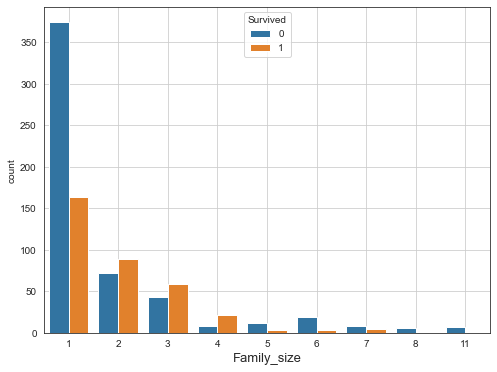

In [140]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x = "Family_size", hue = "Survived", data = train_df)
ax.set_xlabel('Family_size', fontdict={'fontsize':13})
plt.grid();

In [141]:
test_df['Family_size'] = test_df.Parch + test_df.SibSp + 1

Судя по распределению можно выделить группы: 

1. низкая вероятность выжить у одиноких пассажиров, 
2. выше вероятность выжить у семей размером от 2 до 4, 
3. снова низкая вероятность выжить у семей размером от 5 и выше. 

Сделаем биннинг переменной `Family_size` и введем переменную `Family_range`.

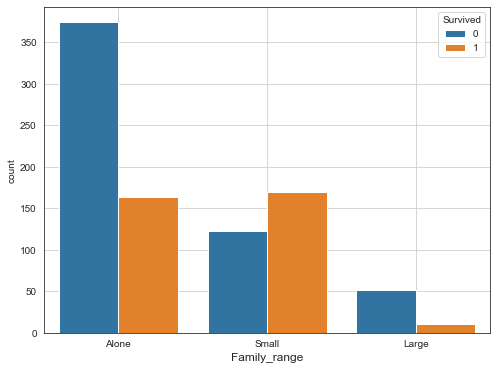

In [142]:
train_df['Family_range'] = pd.cut(train_df.Family_size, bins=[0, 1, 4, np.inf],
                                 labels=['Alone', 'Small', 'Large'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x = "Family_range", hue = "Survived", data = train_df)
ax.set_xlabel('Family_range', fontdict={'fontsize':12})
plt.grid();

In [143]:
test_df['Family_range'] = pd.cut(test_df.Family_size, bins=[0, 1, 4, np.inf],
                                 labels=['Alone', 'Small', 'Large'])

In [144]:
train_df.drop('Family_size', axis=1, inplace=True) 
test_df.drop('Family_size', axis=1, inplace=True)

In [145]:
train_df.drop(['SibSp', 'Parch'], axis=1, inplace=True) 
test_df.drop(['SibSp', 'Parch'], axis=1, inplace=True) 

**`Age`**

Введем переменную, определяемую возрастным диапазоном, и рассмотрим целевую переменную в каждом возрастном диапазоне.

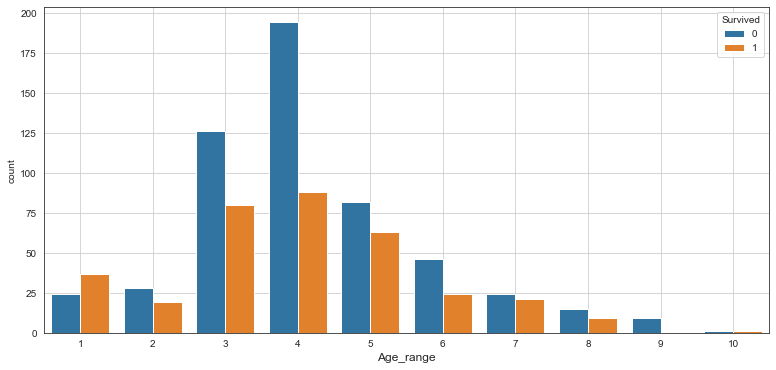

In [146]:
train_df['Age_range'] = pd.cut(train_df.Age, 10,
                               labels=['1', '2', '3', '4', '5',
                                       '6', '7', '8', '9', '10'])

fig, ax = plt.subplots(figsize=(13, 6))
sns.countplot(x = "Age_range", hue = "Survived", data = train_df)
ax.set_xlabel('Age_range', fontdict={'fontsize':12})
plt.grid();

Во всех возрастных категориях погибших было больше, чем выживших, кроме детей до 10 лет.

In [147]:
test_df['Age_range'] = pd.cut(test_df.Age, 10,
                              labels=['1', '2', '3', '4', '5',
                                      '6', '7', '8', '9', '10'])

**`Ticket`**

In [148]:
np.unique(train_df.Ticket.value_counts())
len(train_df.Ticket.value_counts())

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

681

In [149]:
ticket_count = train_df.Ticket.value_counts()

Посмотрим на некоторые группы с одинаковым номером билета.

In [150]:
ticket_count.index[ticket_count > 3]

Index(['347082', 'CA. 2343', '1601', '3101295', 'CA 2144', '347088',
       'S.O.C. 14879', '382652', 'LINE', 'PC 17757', '17421', '349909',
       '113760', '4133', '113781', 'W./C. 6608', '2666', '19950', '347077'],
      dtype='object')

In [151]:
train_df[train_df['Ticket']=='113781']

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Deck,Fare_range,Family_range,Age_range
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,113781,151.55,S,C,Extra_high,Small,1
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,113781,151.55,S,C,Extra_high,Small,1
498,499,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,113781,151.55,S,C,Extra_high,Small,4
708,709,1,1,"Cleaver, Miss. Alice",female,22.00,113781,151.55,S,abs,Extra_high,Alone,3


In [152]:
train_df[train_df['Ticket']=='S.O.C. 14879']

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Deck,Fare_range,Family_range,Age_range
72,73,0,2,"Hood, Mr. Ambrose Jr",male,21.0,S.O.C. 14879,73.5,S,abs,High,Alone,3
120,121,0,2,"Hickman, Mr. Stanley George",male,21.0,S.O.C. 14879,73.5,S,abs,High,Small,3
385,386,0,2,"Davies, Mr. Charles Henry",male,18.0,S.O.C. 14879,73.5,S,abs,High,Alone,3
655,656,0,2,"Hickman, Mr. Leonard Mark",male,24.0,S.O.C. 14879,73.5,S,abs,High,Small,3
665,666,0,2,"Hickman, Mr. Lewis",male,32.0,S.O.C. 14879,73.5,S,abs,High,Small,4


Судя по фамилиям, одинаковый номер билета может означать не только семью, но также людей, путешествующих вместе, т.е. номер билета можно использовать для создания переменной с учетом групп по билетам. 

In [153]:
train_df['Ticket_range'] = train_df.groupby('Ticket')['Ticket'].transform('count')

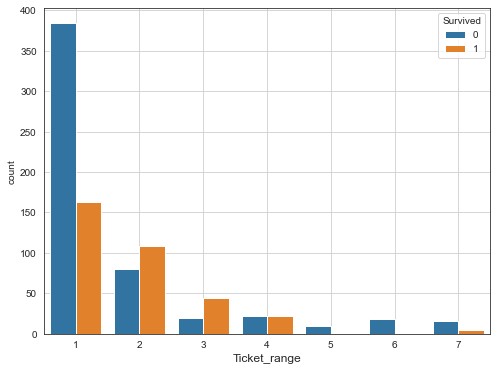

In [154]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x = "Ticket_range", hue = "Survived", data = train_df)
ax.set_xlabel('Ticket_range', fontdict={'fontsize':12})
plt.grid();

Есть зависимость выживаемости, похожая на зависимость от размера семьи, но есть отличия.

Путем биннинга создадим новую переменную `Ticket_group`, в соответствии с найденными паттернами.

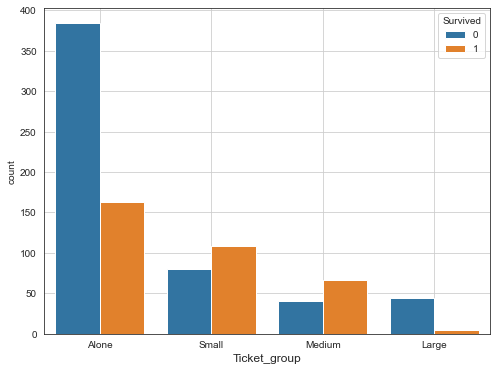

In [155]:
train_df['Ticket_group'] = pd.cut(train_df.Ticket_range, 
                                  bins=[-np.inf, 1, 2, 4, np.inf],
                                  labels=['Alone', 'Small', 
                                          'Medium', 'Large'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x = "Ticket_group", hue = "Survived", data = train_df)
ax.set_xlabel('Ticket_group', fontdict={'fontsize':12})
plt.grid();

In [156]:
test_df['Ticket_range'] = test_df.groupby('Ticket')['Ticket'].transform('count')
test_df['Ticket_group'] = pd.cut(test_df.Ticket_range, 
                                  bins=[-np.inf, 1, 2, 4, np.inf],
                                  labels=['Alone', 'Small', 
                                          'Medium', 'Large'])

In [157]:
train_df.drop('Ticket', axis=1, inplace=True) 
test_df.drop('Ticket', axis=1, inplace=True)

train_df.drop('Ticket_range', axis=1, inplace=True) 
test_df.drop('Ticket_range', axis=1, inplace=True)

In [158]:
gc.collect()

31176

**`Name`**

In [159]:
train_df['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

В переменной `Name` слово до запятой - фамилия - относится к семье, которая учтена ранее. Полезным может быть префикс перед именем.

In [160]:
train_df['Title'] = train_df['Name'].apply(
    lambda x: x.split(",")[1].split('.')[0]).to_frame('title')
train_df['Title'] = train_df['Title'].apply(lambda x: x.strip())

test_df['Title'] = test_df['Name'].apply(
    lambda x: x.split(",")[1].split('.')[0]).to_frame('title')
test_df['Title'] = test_df['Title'].apply(lambda x: x.strip())

In [161]:
train_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [162]:
test_df['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

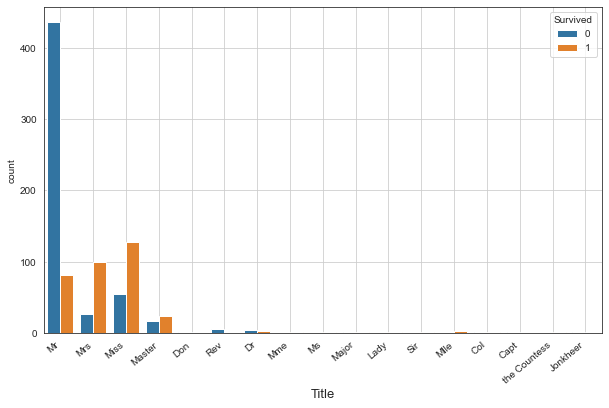

In [163]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x = "Title", hue = "Survived", data = train_df)
ax.set_xlabel('Title', fontdict={'fontsize':13})
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.legend(loc ='upper right', title = 'Survived')
plt.grid();

Значения нужно сгруппировать, уточнив смысл некоторых слов и к какому полу они относятся.

In [164]:
train_df[train_df.Title =='Master']

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Deck,Fare_range,Family_range,Age_range,Ticket_group,Title
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,21.0750,S,abs,Up_middle,Large,1,Medium,Master
16,17,0,3,"Rice, Master. Eugene",male,2.00,29.1250,Q,abs,Up_middle,Large,1,Large,Master
50,51,0,3,"Panula, Master. Juha Niilo",male,7.00,39.6875,S,abs,High,Large,1,Large,Master
59,60,0,3,"Goodwin, Master. William Frederick",male,11.00,46.9000,S,abs,High,Large,2,Large,Master
63,64,0,3,"Skoog, Master. Harald",male,4.00,27.9000,S,abs,Up_middle,Large,1,Large,Master
65,66,1,3,"Moubarek, Master. Gerios",male,25.00,15.2458,C,abs,Up_middle,Small,4,Small,Master
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,29.0000,S,abs,Up_middle,Small,1,Small,Master
125,126,1,3,"Nicola-Yarred, Master. Elias",male,12.00,11.2417,C,abs,Middle,Small,2,Small,Master
159,160,0,3,"Sage, Master. Thomas Henry",male,5.00,69.5500,S,abs,High,Large,1,Large,Master
164,165,0,3,"Panula, Master. Eino Viljami",male,1.00,39.6875,S,abs,High,Large,1,Large,Master


`Master` - такой префикс относится к мальчикам и юношам.

Утотчним еще префикс `Rev`, по остальным пол пассажира понятен. 

In [165]:
train_df[train_df.Title =='Rev']

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Deck,Fare_range,Family_range,Age_range,Ticket_group,Title
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,13.000,S,abs,Middle,Alone,6,Alone,Rev
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,12.525,S,abs,Middle,Alone,7,Alone,Rev
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,26.000,S,abs,Up_middle,Small,7,Small,Rev
626,627,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,12.350,Q,abs,Middle,Alone,8,Alone,Rev
848,849,0,2,"Harper, Rev. John",male,28.0,33.000,S,abs,High,Small,4,Medium,Rev
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,13.000,S,abs,Middle,Alone,4,Alone,Rev


Объединяем префиксы, относящиеся к женскому полу - `Lady` (выживших больше, чем погибших). Из префиксов для мужского пола выделяем группу `Master` (выживших больше, чем погибших), остальные префиксы для мужского пола объединяем - `Mr` (выживших меньше, чем погибших). 

In [166]:
train_df['Title'] = train_df['Title'].replace(['Miss', 'Mrs', 'Mlle', 
                                               'Lady', 'Ms', 'the Countess',
                                               'Mme', 'Dona'],
                                              'Lady')
train_df['Title'] = train_df['Title'].replace(['Dr', 'Rev', 'Col', 
                                               'Major', 'Don', 
                                               'Jonkheer', 'Capt', 'Sir'], 
                                              'Mr')

In [167]:
train_df['Title'].value_counts()

Mr        538
Lady      313
Master     40
Name: Title, dtype: int64

In [168]:
test_df['Title'] = test_df['Title'].replace(['Miss', 'Mrs', 'Mlle', 
                                               'Lady', 'Ms', 'the Countess',
                                               'Mme', 'Dona'],
                                              'Lady')
test_df['Title'] = test_df['Title'].replace(['Dr', 'Rev', 'Col', 
                                               'Major', 'Don', 
                                               'Jonkheer', 'Capt', 'Sir'], 
                                              'Mr')

In [169]:
test_df['Title'].value_counts()

Mr        245
Lady      152
Master     21
Name: Title, dtype: int64

In [170]:
train_df.drop('Name', axis=1, inplace=True) 
test_df.drop('Name', axis=1, inplace=True)

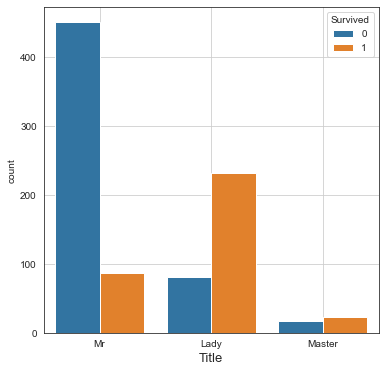

In [171]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.countplot(x = "Title", hue = "Survived", data = train_df)
ax.set_xlabel('Title', fontdict={'fontsize':13})
plt.grid();

In [172]:
train_df.isnull().sum().sum()
test_df.isnull().sum().sum()

0

0

**Числовые переменные**

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


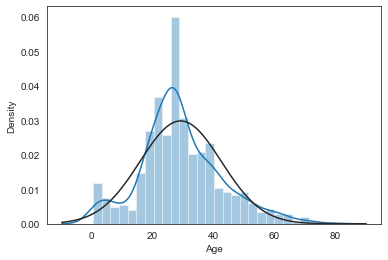

In [173]:
sns.distplot(train_df['Age'], fit=norm);

In [174]:
tr_age_norm = pd.DataFrame(train_df['Age'])
transform_feature = QuantileTransformer(output_distribution='normal',
                                        n_quantiles=418, random_state=0)

tr_age_norm['Age_scaled'] = transform_feature.fit_transform(tr_age_norm[['Age']])

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


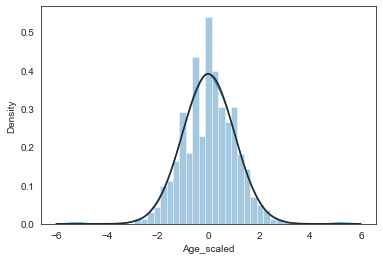

In [175]:
sns.distplot(tr_age_norm['Age_scaled'], fit=norm);

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


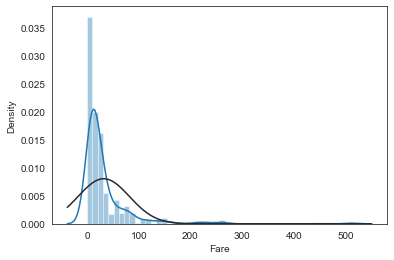

In [176]:
sns.distplot(train_df['Fare'], fit=norm);

In [177]:
tr_fare_norm = pd.DataFrame(train_df['Fare'])

tr_fare_norm['Fare_scaled'] = transform_feature.fit_transform(tr_fare_norm[['Fare']])

c:\Users\biaspaltsau_aa\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


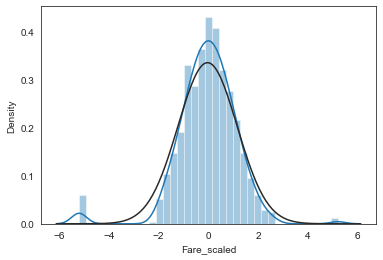

In [178]:
sns.distplot(tr_fare_norm['Fare_scaled'], fit=norm);

Масштабирование переменных `Age` и `Fare` не помогло привести распределение к нормальному, в случае `Fare` это понятно и визуально. Пробовался также `RobustScaler`, результат был примерно тот же.

In [179]:
train_df['Age_scaled'] = transform_feature.fit_transform(train_df[['Age']])
test_df['Age_scaled'] = transform_feature.transform(test_df[['Age']])

train_df['Fare_scaled'] = transform_feature.fit_transform(train_df[['Fare']])
test_df['Fare_scaled'] = transform_feature.transform(test_df[['Fare']])

In [180]:
train_df_num = pd.concat((train_df['Age_scaled'], 
                          train_df['Fare_scaled']), axis=1)
test_df_num = pd.concat((test_df['Age_scaled'], 
                          test_df['Fare_scaled']), axis=1)

In [181]:
train_df.drop(['Age', 'Fare'], axis=1, inplace=True) 
test_df.drop(['Age', 'Fare'], axis=1, inplace=True) 

In [182]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Embarked,Deck,Fare_range,Family_range,Age_range,Ticket_group,Title,Age_scaled,Fare_scaled
0,1,0,3,male,S,abs,Low,Small,3,Alone,Mr,-0.606226,-1.371357
1,2,1,1,female,C,C,High,Small,5,Alone,Lady,0.746053,1.200469
2,3,1,3,female,S,abs,Middle,Alone,4,Alone,Lady,-0.249004,-0.642754
3,4,1,1,female,S,C,High,Small,5,Small,Lady,0.570490,0.991702
4,5,0,3,male,S,abs,Middle,Alone,5,Alone,Mr,0.570490,-0.535468


In [183]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   PassengerId   891 non-null    int64   
 1   Survived      891 non-null    int64   
 2   Pclass        891 non-null    int64   
 3   Sex           891 non-null    object  
 4   Embarked      891 non-null    object  
 5   Deck          891 non-null    object  
 6   Fare_range    891 non-null    category
 7   Family_range  891 non-null    category
 8   Age_range     891 non-null    category
 9   Ticket_group  891 non-null    category
 10  Title         891 non-null    object  
 11  Age_scaled    891 non-null    float64 
 12  Fare_scaled   891 non-null    float64 
dtypes: category(4), float64(2), int64(3), object(4)
memory usage: 67.2+ KB


In [184]:
train_df.Pclass = train_df.Pclass.astype("category")
test_df.Pclass = test_df.Pclass.astype("category")

In [185]:
cat_columns = [i for i in train_df.columns if 
               train_df[i].dtype.name=='category' or 
               train_df[i].dtype.name=='object']

In [186]:
cat_columns

['Pclass',
 'Sex',
 'Embarked',
 'Deck',
 'Fare_range',
 'Family_range',
 'Age_range',
 'Ticket_group',
 'Title']

In [187]:
train_df_catdummy = pd.get_dummies(train_df[cat_columns])
test_df_catdummy = pd.get_dummies(test_df[cat_columns])

In [188]:
train_df_all = pd.concat((train_df_num, train_df_catdummy), axis=1)
test_df_all = pd.concat((test_df_num, test_df_catdummy), axis=1)

In [189]:
train_df_all.head()
train_df_all.shape

,Age_scaled,Fare_scaled,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_abs,Fare_range_Low,Fare_range_Middle,Fare_range_Up_middle,Fare_range_High,Fare_range_Extra_high,Family_range_Alone,Family_range_Small,Family_range_Large,Age_range_1,Age_range_2,Age_range_3,Age_range_4,Age_range_5,Age_range_6,Age_range_7,Age_range_8,Age_range_9,Age_range_10,Ticket_group_Alone,Ticket_group_Small,Ticket_group_Medium,Ticket_group_Large,Title_Lady,Title_Master,Title_Mr
0,-0.606226,-1.371357,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.746053,1.200469,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
2,-0.249004,-0.642754,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,0.570490,0.991702,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,0.570490,-0.535468,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


(891, 43)

In [190]:
test_df_all.head()
test_df_all.shape

,Age_scaled,Fare_scaled,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_abs,Fare_range_Low,Fare_range_Middle,Fare_range_Up_middle,Fare_range_High,Fare_range_Extra_high,Family_range_Alone,Family_range_Small,Family_range_Large,Age_range_1,Age_range_2,Age_range_3,Age_range_4,Age_range_5,Age_range_6,Age_range_7,Age_range_8,Age_range_9,Age_range_10,Ticket_group_Alone,Ticket_group_Small,Ticket_group_Medium,Ticket_group_Large,Title_Lady,Title_Master,Title_Mr
0,0.541314,-0.897777,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,1.257333,-1.879201,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
2,2.070888,-0.330029,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,-0.087272,-0.417573,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,-0.606226,-0.197906,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


(418, 43)

## Дополнительно - примеры задач.

## 1. Дерево решений без настройки параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. 

In [191]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df_all, y, test_size=0.3, random_state=17)

dtree = DecisionTreeClassifier(max_depth=2, random_state=17)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [192]:
y_pred_dtree = dtree.predict(test_df_all)

In [193]:
submission_dtree = pd.DataFrame({
    'PassengerId': test_df.PassengerId,
    'Survived': y_pred_dtree
})
submission_dtree.Survived = submission_dtree.Survived.astype(int)
submission_dtree.to_csv("submission_dtree.csv", index=False)

**0.78468**

**Отобразите дерево с помощью `export_graphviz` и `dot`.**

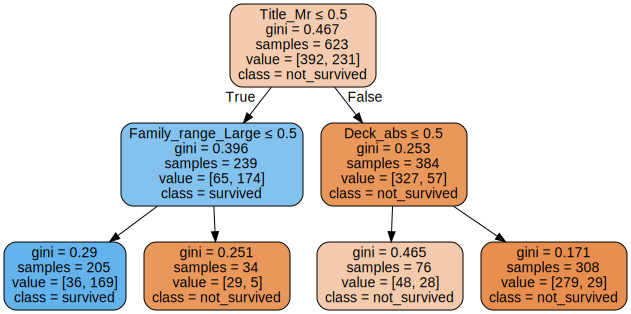

In [194]:
# Для отображения в дереве сделаем строковый вариант целевой переменной
y_str = np.where(y == 0, "not_survived", "survived")

dot_data = export_graphviz(
    dtree,
    out_file=None,
    feature_names=train_df_all.columns,
    class_names=y_str,
    filled=True,
    rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph

***Цвет узлов***: чем больше объектов класса "1", тем цвет узла ближе к темно-оранжевому, чем больше объектов класса "0", тем ближе цвет к темно-синему. Если объектов одного класса поровну, то узел дерева белого цвета.

## 2. Дерево решений с настройкой параметров 

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`). Максимальную глубину и минимальное число элементов в листе настройте на 5-кратной кросс-валидации с помощью `GridSearchCV`.**

In [195]:
# tree params for grid search
tree_params = {
    'max_depth': list(range(1, 5)),
    'min_samples_leaf': list(range(1, 5))
}

# 5-кратная кросс-валидация установлена по умолчанию (параметр cv=5)
dtree_grid = GridSearchCV(dtree, tree_params, n_jobs=-1, verbose=True)
dtree_grid.fit(X_train, y_train)

dtree_grid.best_params_
dtree_grid.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=DecisionTreeClassifier(max_depth=2, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_samples_leaf': [1, 2, 3, 4]},
             verbose=True)

{'max_depth': 3, 'min_samples_leaf': 2}

0.8362451612903226

<font color='red'>Вопрос 3. </font> Каковы лучшие параметры дерева, настроенные на кросс-валидации с помощью `GridSearchCV`?

In [196]:
dtree_grid.best_params_

{'max_depth': 3, 'min_samples_leaf': 2}

<font color='red'>Вопрос 4. </font> Какой получилась средняя доля верных ответов на кросс-валидации для дерева решений с лучшим сочетанием гиперпараметров `max_depth` и `min_samples_leaf`?

In [197]:
dtree_grid.best_score_

0.8362451612903226

In [198]:
cross_val_score(dtree_grid, train_df_all, y).mean()

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


0.8215240725629277

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [199]:
y_pred = dtree_grid.predict(test_df_all)

**Сформируйте файл посылки и отправьте на Kaggle.**

In [200]:
submission_dt_grid = pd.DataFrame({
    'PassengerId': test_df.PassengerId,
    'Survived': y_pred
})
submission_dt_grid.Survived = submission_dt_grid.Survived.astype(int)
submission_dt_grid.to_csv("submission_dt_grid.csv", index=False)

<font color='red'>Вопрос 5. </font> Каков результат второй посылки (дерево решений с настройкой гиперпараметров) в публичном рейтинге соревнования Titanic?

**0.78947**

## 3. Дополнительные модели, сравнение эффективности после настройки параметров.

### RandomForest

In [201]:
rf = RandomForestClassifier(
    n_estimators=1000, max_depth=17, random_state=2020, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, n_estimators=1000, n_jobs=-1,
                       random_state=2020)

In [202]:
y_val_pred_rf = rf.predict(X_val)
accuracy_score(y_val, y_val_pred_rf)

0.8059701492537313

In [203]:
cross_val_score(rf, train_df_all, y).mean()

0.8170673529596384

In [204]:
y_pred_rf = rf.predict(test_df_all)

In [205]:
submission_rf = pd.DataFrame({
    'PassengerId': test_df.PassengerId,
    'Survived': y_pred_rf
})
submission_rf.Survived = submission_rf.Survived.astype(int)
submission_rf.to_csv("submission_rf.csv", index=False)

**Результат посылки** 

**0.77033**

Настройка параметров `RandomForestClassifier` с **hyperopt**, потому что `GridSearchCV` слишком долго обрабатывал. 

In [206]:
my_scorer = make_scorer(accuracy_score)

In [207]:
def hyperopt_forest_score(params):
    clf = RandomForestClassifier(**params, n_jobs=-1)
    current_score = cross_val_score(
        clf, train_df_all, y, scoring=my_scorer).mean()
    print(current_score, params)
    return -current_score


space_forest = {
    'max_depth': hp.choice('max_depth', range(5, 20)),
    'n_estimators': hp.choice('n_estimators', range(500, 1500)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

In [208]:
best = fmin(
    fn=hyperopt_forest_score,
    space=space_forest,
    algo=tpe.suggest,
    max_evals=20,
    verbose=0)
print('best:', best)

0.8125729709371665 {'criterion': 'entropy', 'max_depth': 19, 'n_estimators': 1202}
0.8103320569957944 {'criterion': 'gini', 'max_depth': 19, 'n_estimators': 792}
0.824913690289373 {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 726}
0.822666499278137 {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 545}
0.8170610758897746 {'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 994}
0.8383717280773336 {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 1263}
0.838390559286925 {'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 884}
0.8260372857949909 {'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 858}
0.8372481325717155 {'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 717}
0.8316364321134895 {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 776}
0.8148264390182662 {'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 1189}
0.824913690289373 {'criterion': 'gini', 'max_depth': 14, 'n_estimators': 911}
0.8170736300295023 {'criterion': '

In [209]:
# Модель RandomForest после подбора параметров
forest_tuned = RandomForestClassifier(
    n_estimators=193,
    max_depth=4,
    random_state=42,
    n_jobs=-1,
    criterion="gini")
forest_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=193, n_jobs=-1,
                       random_state=42)

In [210]:
y_val_pred_rftuned = forest_tuned.predict(X_val)
accuracy_score(y_val, y_val_pred_rftuned)

0.8022388059701493

In [211]:
cross_val_score(forest_tuned, train_df_all, y).mean()

0.8271420500910175

In [212]:
y_pred_rf_tuned = forest_tuned.predict(test_df_all)

In [213]:
submission_rf_tuned = pd.DataFrame({
    'PassengerId': test_df.PassengerId,
    'Survived': y_pred_rf_tuned
})
submission_rf_tuned.Survived = submission_rf_tuned.Survived.astype(int)
submission_rf_tuned.to_csv("submission_rf_tuned.csv", index=False)

**Результат посылки после подбора параметров**

**0.79425**

### SVC

In [214]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [215]:
svm_rbf = SVC(kernel='rbf', class_weight='balanced').fit(train_df_all, y)

cross_val_score(svm_rbf, train_df_all, y, cv=skf).mean()

0.8305630531667818

In [216]:
y_pred_svm = svm_rbf.predict(test_df_all)

In [217]:
submission_svm = pd.DataFrame({'PassengerId': test_df.PassengerId,
                           'Survived': y_pred_svm})
submission_svm.Survived = submission_svm.Survived.astype(int)
submission_svm.to_csv("submission_svm.csv", index=False)

**Результат посылки**

**0.77511**

In [218]:
svc_params = {
    'C': [x / 10.0 for x in range(10, 30, 1)],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovr', 'ovo']
}

svc_grid = GridSearchCV(svm_rbf, svc_params, n_jobs=-1, verbose=True)
svc_grid.fit(X_train, y_train)

svc_grid.best_params_
svc_grid.best_score_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9,
                               2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8,
                               2.9],
                         'decision_function_shape': ['ovr', 'ovo'],
                         'gamma': ['scale', 'auto']},
             verbose=True)

{'C': 2.5, 'decision_function_shape': 'ovr', 'gamma': 'auto'}

0.8458580645161291

In [219]:
cross_val_score(svc_grid, train_df_all, y, cv=skf).mean()

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


0.8305567760969179

In [220]:
y_pred_svc_grid = svc_grid.predict(test_df_all)

In [221]:
submission_svc_grid = pd.DataFrame({
    'PassengerId': test_df.PassengerId,
    'Survived': y_pred_svc_grid
})
submission_svc_grid.Survived = submission_svc_grid.Survived.astype(int)
submission_svc_grid.to_csv("submission_svc_grid.csv", index=False)

**Результат посылки после подбора параметров**

**0.78947**

### CatBoostClassifier

In [222]:
cat = CatBoostClassifier(verbose=None, random_seed=42)
cat.fit(X_train, y_train)

Learning rate set to 0.008417
0:	learn: 0.6879150	total: 164ms	remaining: 2m 43s
1:	learn: 0.6825915	total: 170ms	remaining: 1m 24s
2:	learn: 0.6766021	total: 175ms	remaining: 58s
3:	learn: 0.6711912	total: 178ms	remaining: 44.2s
4:	learn: 0.6652235	total: 181ms	remaining: 36s
5:	learn: 0.6594110	total: 183ms	remaining: 30.4s
6:	learn: 0.6535921	total: 186ms	remaining: 26.3s
7:	learn: 0.6475160	total: 188ms	remaining: 23.3s
8:	learn: 0.6415181	total: 190ms	remaining: 20.9s
9:	learn: 0.6364768	total: 192ms	remaining: 19s
10:	learn: 0.6306216	total: 194ms	remaining: 17.4s
11:	learn: 0.6260941	total: 196ms	remaining: 16.1s
12:	learn: 0.6206575	total: 197ms	remaining: 15s
13:	learn: 0.6161183	total: 199ms	remaining: 14s
14:	learn: 0.6119856	total: 200ms	remaining: 13.1s
15:	learn: 0.6067553	total: 201ms	remaining: 12.4s
16:	learn: 0.6019559	total: 202ms	remaining: 11.7s
17:	learn: 0.5974161	total: 204ms	remaining: 11.1s
18:	learn: 0.5926269	total: 205ms	remaining: 10.6s
19:	learn: 0.588147

In [223]:
cat_params = {
    'iterations': [700, 1000, 1500],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7]
}

cat_grid = GridSearchCV(cat, cat_params, n_jobs=-1, verbose=True)
cat_grid.fit(X_train, y_train)

cat_grid.best_params_
cat_grid.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
y_pred_cat = cat_grid.predict(test_df_all)

In [ ]:
submission_cat = pd.DataFrame({
    'PassengerId': test_df.PassengerId,
    'Survived': y_pred_cat
})
submission_cat.Survived = submission_cat.Survived.astype(int)
submission_cat.to_csv("submission_cat.csv", index=False)

**Результат посылки после подбора параметров catboost**

**0.76555**

Для лучшего предсказания (`RandomForest` после подбора параметров) построим `confusion_matrix`.

In [ ]:
y_pred_train = rf_tuned.predict(train_df_all)

NameError: name 'rf_tuned' is not defined

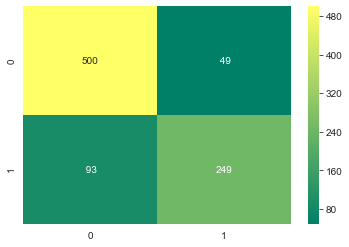

In [ ]:
sns.heatmap(confusion_matrix(y, y_pred_train), annot=True,
            fmt='3.0f', cmap="summer");

### Выводы

Настройка параметров повышает предсказательную способность моделей.

В данной работе наилучший результат был достигнут `RandomForestClassifier` после настройки параметров **hyperopt**.

Настройка параметров с помощью `GridSearchCV` зачастую работает очень медленно (зависит от модели).